# [Workshop: Software Tools from Atomistics to Phase Diagrams](https://workshop.materialsgenomefoundation.org) 

## Day 1 - Atomistic simulations ([pyiron](https://pyiron.org))
**Authors:  <u>Jan Janssen</u>, Tilmann Hickel, Jörg Neugebauer ([Max-Planck-Institut für Eisenforschung](https://www.mpie.de))**

Interactive: **Atomistic simulations with pyiron**

The scope of this second exercise is to become familar with:
* Interatomic potential calculation, 
* the pyiron job management and
* the aggregation of multiple calculations.

## Reminder
In the first session we learned how to create a pyiron project object and then use this pyiron project object to create atomistic structure objects. 

In [1]:
# Import the Project object
from pyiron import Project

In [2]:
# Create a Project object instance for a project named atomistics
pr = Project("simulations")

In [3]:
# Create a cubic aluminum fcc structure and repeat it 3 times in each direction
al_fcc = pr.create_ase_bulk("Al", cubic=True)
al_fcc_repeated = al_fcc.repeat(3)

In [4]:
# Confirm the final structure has 108 atoms by calculating the length of the structure object
len(al_fcc_repeated) == 108

True

## LAMMPS Calculation 
The Large-scale Atomic/Molecular Massively Parallel Simulator (LAMMPS) code is used inside pyiron for atomistic simualtion with interatomic potentials. These interatomic potentials approximate the interaction of atoms and can be either fitted to density functional theory (DFT) or experimental results. Still in contrast to density functional theory which scales cubically with the number of atoms interatomic potentials scale linearly with the number of atoms. Therefore we are going to use primarly interatomic potentials in this workshop but most calculations could be executed with a DFT codes as well. 

### Molecular dynamics calculation
We start with a first molecular dynamic calculation at an ensemble with constant number of atoms, constant volume and contant fixed temperature.

In [5]:
# Create a LAMMPS job object with the job named lmp
job_md = pr.create_job(
    job_type=pr.job_type.Lammps, 
    job_name="lmp"
)

In [6]:
# Assign the fcc aluminium structure to the LAMMPS job object
job_md.structure = al_fcc_repeated

In [7]:
# Define an ensemble with constant number of atoms, 
# constant volume and a constant temperature of 500K 
# and simulate 10000 molecular dynamics steps
job_md.calc_md(temperature=500, n_ionic_steps=10000)

In [8]:
# Execute the calculation - You get a warning that 
# not potential was set and the default potential was
# used instead. The selection of interatomic potentials 
# is discussed below.
job_md.run(delete_existing_job=True)

/opt/conda/lib/python3.8/site-packages/pyiron/lammps/base.py:229: UserWarning: No potential set via job.potential - use default potential, Al_Mg_Mendelev_eam
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job lmp was saved and received the ID: 75


In [9]:
# Animate the molecular dynamics trajectory
job_md.animate_structure()

NGLWidget(max_frame=100)

### Reminder: Job Management in pyiron
After the successful execution of the calculation it is listed in the project database and can be reloaded using either the job name or the job id, therefore theese have to be unique for a given project. 

In [10]:
# list all calculations in the current project using the project job table
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,75,finished,Al108,lmp,/lmp,/home/jovyan/,again/simulations/,2020-11-09 23:36:28.580266,2020-11-09 23:36:37.899903,9.0,pyiron@jupyter-jan#1,Lammps,0.1,None,None


As discussed in the previous section by default pyiron calculations are reloaded from the database when a calculation with the same name already exists in a given project. Therefore to overwrite the calculation parameters we use `delete_existing_job` parameter in the `run()` function. 

In [11]:
# Change the temperature to 800K and calculate 20000 steps.
# You get a warning message that the job is already finished. 
job_md.calc_md(temperature=800, n_ionic_steps=20000)

/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/parameters.py:284: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


In [12]:
# Execute the LAMMPS calculation by calling the run function 
# with the delete_existing parameter set to true: 
job_md.run(delete_existing_job=True)

The job lmp was saved and received the ID: 75


### Reminder: Plot calculation results using matplotlib 
In the same way we can again use matplotlib to analyse the results of our calculation. For example we can use the matplotlib library to plot the temperature over simulation steps.

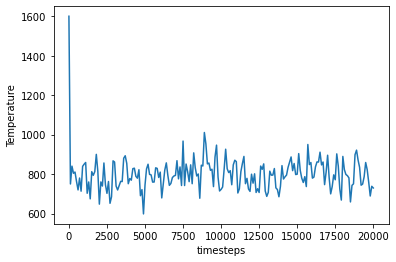

In [13]:
# Import the matplotlib library for plotting. 
import matplotlib.pyplot as plt

# for the LAMMPS job object plot the temperature over simualation steps
plt.plot(job_md.output.steps, job_md.output.temperature)
plt.xlabel("timesteps")
plt.ylabel("Temperature");

In the beginning the potential energy is close to the 0K equilibrium, therefore to accelerate the equilibration the kinetic energy is set to twice the expected kinetic energy. The additional kinetic energy is transfered to the potential energy resulting in an equal distribution of potential and kinetic energy. With this trick the equilibration is accelerated. The large temperature fluctuations are related to the small number of atoms in the simulation cell.

### Advanced input options
Besides the general functions `calc_static()`, `calc_minimize()` and `calc_md()`. pyiron also has the option to modify the input of the simulation code directly. 

In [14]:
# display the LAMMPS input file 
job_md.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all nvt temp 800.0 800.0 0.1,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


In [15]:
# change the number of simulation steps to 2000 
# by manually modifying the run command.
# You again get a warning message that the job 
# is already finished. 
job_md.input.control["run"] = 2000

/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/parameters.py:284: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


### Advanced output options 
Besides the output properties it is also possible to access the output of a calculation directly from the data interface which is based om the hierachical file format (HDF5) pyiron is using to store the simulation data.

In [16]:
# print content of the job object 
job_md

{'groups': ['input', 'output'], 'nodes': ['HDF_VERSION', 'NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [17]:
# print content of the output of the job object
# use strings to specify the path for the data interface 
job_md["output"]

{'groups': ['generic', 'structure'], 'nodes': []}

In [18]:
# print content of the generic group 
# of the output of the job object 
job_md["output/generic"]

{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

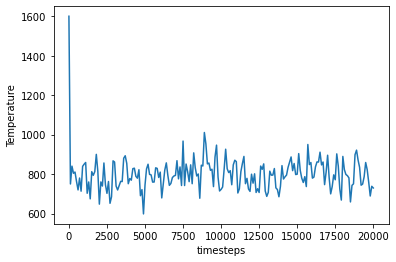

In [19]:
# plot the temperature over simulation steps directly from the HDF5 file 
plt.plot(job_md["output/generic/steps"], job_md["output/generic/temperature"])
plt.xlabel("timesteps")
plt.ylabel("Temperature");

### Accessing the original output files of the LAMMPS code
While pyiron parses most of the output of the simulation codes some users might have the need to access addtional output parameters. 

In [20]:
# Decompress the LAMMPS job
job_md.decompress()

In [21]:
# Read the LAMMPS output file of the LAMMPS job
job_md["log.lammps"]

['LAMMPS (3 Mar 2020)\n',
 'units metal\n',
 'dimension 3\n',
 'boundary p p p\n',
 'atom_style atomic\n',
 'read_data structure.inp\n',
 '  orthogonal box = (0 0 0) to (12.15 12.15 12.15)\n',
 '  1 by 1 by 1 MPI processor grid\n',
 '  reading atoms ...\n',
 '  108 atoms\n',
 '  read_data CPU = 0.00113201 secs\n',
 'include potential.inp\n',
 'pair_style eam/fs\n',
 'pair_coeff * * Al-Mg.eam.fs Al Mg\n',
 'fix ensemble all nvt temp 800.0 800.0 0.1\n',
 'variable dumptime  equal 100\n',
 'variable thermotime  equal 100\n',
 'timestep 0.001\n',
 'velocity all create 1600.0 61040 dist gaussian\n',
 'dump 1 all custom ${dumptime} dump.out id type xsu ysu zsu fx fy fz vx vy vz\n',
 'dump 1 all custom 100 dump.out id type xsu ysu zsu fx fy fz vx vy vz\n',
 'dump_modify 1 sort id format line "%d %d %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g"\n',
 'thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol\n',
 'thermo_modify format float %20.15g\n',
 'the

## Beyond a single LAMMPS calculation
While for individual LAMMPS calculation an integrated solution like pyiron is not required, pyiron really shines when it comes to combining multiple calculations. So in the following we iterate over a database of existing interatomic potentials and determine the lattice structure by minimizing the simulation cell.   

### Filter Interatomic Potential Database
We start by identifying suitable interatomic potentials. By default pyiron already filters the interatomic potentials to only list those which include the required elements. Still the user can further filter the list of available potentials for a given project. 

In [22]:
# List interatomic potentials from the NIST repository: 
# https://www.ctcms.nist.gov/potentials/
# which include interactions for aluminium by calling view_potentials() on the LAMMPS job object
potential_df = job_md.view_potentials()
potential_df[potential_df.Model == "NISTiprpy"]

,Config,Filename,Model,Name,Species
0,"[pair_style eam/fs \n, pair_coeff * * Al-Mg.eam.fs Al Mg\n]",[potential_LAMMPS/2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1/Al-Mg.eam.fs],NISTiprpy,Al_Mg_Mendelev_eam,"[Al, Mg]"
1,"[pair_style eam/alloy \n, pair_coeff * * Zope-Ti-Al-2003.eam.alloy Ti Al\n]",[potential_LAMMPS/2003--Zope-R-R--Ti-Al--LAMMPS--ipr1/Zope-Ti-Al-2003.eam.alloy],NISTiprpy,Zope_Ti_Al_2003_eam,"[Ti, Al]"
2,"[pair_style eam/alloy \n, pair_coeff * * NiAlH_jea.eam.alloy Ni Al H\n]",[potential_LAMMPS/1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1/NiAlH_jea.eam.alloy],NISTiprpy,Al_H_Ni_Angelo_eam,"[Ni, Al, H]"
13,"[pair_style meam/c\n, pair_coeff * * MgAlZn.library.meam Mg Al MgAlZn.parameter.meam Mg Al Zn\n]","[potential_LAMMPS/2018--Dickel-D-E--Mg-Al-Zn--LAMMPS--ipr1/MgAlZn.parameter.meam, potential_LAMMPS/2018--Dickel-D-E--Mg-Al-Zn--LAMMPS--ipr1/MgAlZn.library.meam]",NISTiprpy,2018--Dickel-D-E--Mg-Al-Zn--LAMMPS--ipr1,"[Mg, Al, Zn]"
34,"[pair_style eam/alloy\n, pair_coeff * * alpb-setfl.eam.alloy Al Pb\n]",[potential_LAMMPS/2000--Landa-A--Al-Pb--LAMMPS--ipr1/alpb-setfl.eam.alloy],NISTiprpy,2000--Landa-A--Al-Pb--LAMMPS--ipr1,"[Al, Pb]"
44,"[pair_style eam/alloy\n, pair_coeff * * Al_Zhou04.eam.alloy Al\n]",[potential_LAMMPS/2004--Zhou-X-W--Al--LAMMPS--ipr2/Al_Zhou04.eam.alloy],NISTiprpy,2004--Zhou-X-W--Al--LAMMPS--ipr2,[Al]
51,"[pair_style eam/alloy\n, pair_coeff * * Al03.eam.alloy Al\n]",[potential_LAMMPS/2003--Zope-R-R--Al--LAMMPS--ipr1/Al03.eam.alloy],NISTiprpy,2003--Zope-R-R--Al--LAMMPS--ipr1,[Al]
57,"[pair_style eam/fs\n, pair_coeff * * Al90Sm10_MendelevM_2014.eam.fs Al Sm\n]",[potential_LAMMPS/2015--Mendelev-M-I--Al-Sm--LAMMPS--ipr1/Al90Sm10_MendelevM_2014.eam.fs],NISTiprpy,2015--Mendelev-M-I--Al-Sm--LAMMPS--ipr1,"[Al, Sm]"
59,"[pair_style eam/alloy\n, pair_coeff * * mg-al-set.eam.alloy Al Mg\n]",[potential_LAMMPS/1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1/mg-al-set.eam.alloy],NISTiprpy,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,"[Al, Mg]"
64,"[pair_style eam/alloy\n, pair_coeff * * Al.set Al\n]",[potential_LAMMPS/2004--Zhou-X-W--Al--LAMMPS--ipr1/Al.set],NISTiprpy,2004--Zhou-X-W--Al--LAMMPS--ipr1,[Al]


### Choose an interatmoic potential
Interatomic potentials can be fitted for specific applications, therefore before selecting a given interatomic potential it is recommended to test basic properties of the potential. In this example we calculate the 0K equilibrium lattice constant by optimizing the atmoic supercell. 

#### Job Template
To develop a scalable simulation protocol, we first define a job template and then apply this template to the available interatomic potentials.

In [23]:
# To compare different potentials we start by creating a template job named lmp_template
job_template = pr.create_job(
    job_type=pr.job_type.Lammps, 
    job_name="lmp_template"
)

In [24]:
# We assign a cubic fcc aluminium supercell 
job_template.structure = pr.create_ase_bulk("Al", cubic=True)

In [25]:
# Enable volume minimization by specifying the pressure as zero
job_template.calc_minimize(pressure=0.0)

#### Iterate over interatomic potentials
After the template is constructed we can iterate over the database of existing interatomic potentials. In this example we limit the total umber of potentials to three to accelerate the calculations. 

In [26]:
# Select the first three potentials from the NIST database
potential_df[potential_df.Model == "NISTiprpy"].Name.values[:3]

array(['Al_Mg_Mendelev_eam', 'Zope_Ti_Al_2003_eam', 'Al_H_Ni_Angelo_eam'],
      dtype=object)

In [27]:
# We then iterate over the first three potentials of the NIST database
for p in potential_df[potential_df.Model == "NISTiprpy"].Name.values[:3]:
    # create a copy for each of the template job for each of the potentials
    # without creating a new database entry by setting the new_database_entry 
    # parameter to False 
    job_minimize = job_template.copy_to(
        new_job_name="lmp_" + p.replace("-", "_"), 
        new_database_entry=False
    )
    
    # We then assign the potential 
    job_minimize.potential = p
    
    # Execute the calculation 
    job_minimize.run(delete_existing_job=True)

The job lmp_Al_Mg_Mendelev_eam was saved and received the ID: 76
The job lmp_Zope_Ti_Al_2003_eam was saved and received the ID: 77
The job lmp_Al_H_Ni_Angelo_eam was saved and received the ID: 78


In [28]:
# list all calculations in the current project using the project job table
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,75,finished,Al108,lmp,/lmp,/home/jovyan/,again/simulations/,2020-11-09 23:36:41.970727,2020-11-09 23:36:52.541898,10.0,pyiron@jupyter-jan#1,Lammps,0.1,None,None
1,76,finished,Al4,lmp_Al_Mg_Mendelev_eam,/lmp_Al_Mg_Mendelev_eam,/home/jovyan/,again/simulations/,2020-11-09 23:37:00.285287,2020-11-09 23:37:02.967963,2.0,pyiron@jupyter-jan#1,Lammps,0.1,None,None
2,77,finished,Al4,lmp_Zope_Ti_Al_2003_eam,/lmp_Zope_Ti_Al_2003_eam,/home/jovyan/,again/simulations/,2020-11-09 23:37:08.665310,2020-11-09 23:37:10.641839,1.0,pyiron@jupyter-jan#1,Lammps,0.1,None,None
3,78,finished,Al4,lmp_Al_H_Ni_Angelo_eam,/lmp_Al_H_Ni_Angelo_eam,/home/jovyan/,again/simulations/,2020-11-09 23:37:15.027790,2020-11-09 23:37:16.947035,1.0,pyiron@jupyter-jan#1,Lammps,0.1,None,None


#### Validate calculations
We validate the simulation results by confirming the calculations have been executed successfully. In this example one calculation failed. 

In [29]:
# We use the pyiron job table of the project object 
# to validate all jobs finished successfully with 
# the status "finished"
df = pr.job_table()
len(df[df.status == "finished"]) == 4

True

#### Analyse results
Iterate over the successful calculation and compare the calculated lattice constants. 

In [30]:
# load a job object by the job name in the column job 
# of the pyiron job table 
job = pr.load(job_minimize.job_name)

job_minimize.job_name

'lmp_Al_H_Ni_Angelo_eam'

In [31]:
# print the final lattice constant 
job["output/generic/cells"][-1,0,0]

4.050000068034437

In [32]:
# We iterate over the jobs in a the current project 
for job in pr.iter_jobs():
    # Filter job using only those who have the job status 
    # finished and "lmp_" in the job_name
    if job.status == "finished" and "lmp_" in job.job_name: 
        # Print the job name and the lattice constant 
        print(job.job_name, job["output/generic/cells"][-1,0,0])

lmp_Al_Mg_Mendelev_eam 4.045270541092276
lmp_Zope_Ti_Al_2003_eam 4.049999419544279
lmp_Al_H_Ni_Angelo_eam 4.050000068034437


#### pyiron table 
To automate the collection of data from individual calculations pyiron includes the pyiron table object. 

In [33]:
# Create a pyiron table object
table = pr.create_table()

In [34]:
# Implement a filter function, which returns true 
# for finished jobs and jobs with "lmp_" in the job_name
def filter_jobs(job):
    return job.status == "finished" and "lmp_" in job.job_name

In [35]:
# Implement an analysis functions, which takes a job object
# as an input and returns the lattice constant. Based on the
# previous cell above to print the lattice constant.
def get_lattice_constant(job): 
    return job["output/generic/cells"][-1,0,0]

In [36]:
# Implement a second analysis functions, which takes a 
# job object as an input and returns the job_name.
def get_job_name(job):
    return job.job_name

In [37]:
# Assigne the filter functions and the analysis functions 
# to the pyiron table object
table.filter_function = filter_jobs
table.add["job_name"] = get_job_name
table.add["lattice_constant"] = get_lattice_constant

In [38]:
# Execute the pyiron table just like a pyiron job object
table.run()

  0%|          | 0/3 [00:00<?, ?it/s]

The job table was saved and received the ID: 79


100%|██████████| 3/3 [00:00<00:00, 61.96it/s]


In [39]:
# Return a pandas DataFrame with the collected results 
table.get_dataframe()

,job_id,job_name,lattice_constant
0,76,lmp_Al_Mg_Mendelev_eam,4.045271
1,77,lmp_Zope_Ti_Al_2003_eam,4.049999
2,78,lmp_Al_H_Ni_Angelo_eam,4.050000


## Summary 
In this section you learned:
* to execute LAMMPS calculation with generic and code-specifc input,
* to iterate over multiple interatomic potentials
* and aggregate the data in a pyiron table object. 
This technique was afterwards used to calculate the lattice constant of multiple interatomic potentials. 

Additional exercises: 
* Calculate the lattice constant at a finite temperature of 500K by averaging the lattice constant over 1000 time steps. 
* Calculate the thermal expansion for multiple potentials. 
* How does an interstitial element change the thermal expansion? How does a vacancy change the thermal expansion? 